## Solving combinatorial optimization problems using QAOA

In [134]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from dwave_qbsolv import QBSolv
from matplotlib import pyplot as plt
from pennylane import qaoa
import copy
import progressbar
import os
import os.path
from qiskit import IBMQ

import dimod.utilities

In [135]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

In [136]:
from scipy.optimize import minimize

The **problem Hamiltonian** specific to the Max-Cut problem up to a constant here is:

$$
H_{P}=\frac{1}{2}\left(Z_{0} \otimes Z_{1} \otimes I_{2} \otimes I_{3}\right)+\frac{1}{2}\left(I_{0} \otimes Z_{1} \otimes Z_{2} \otimes I_{3}\right)+\frac{1}{2}\left(Z_{0} \otimes I_{1} \otimes I_{2} \otimes Z_{3}\right)+\frac{1}{2}\left(I_{0} \otimes I_{1} \otimes Z_{2} \otimes Z_{3}\right)
$$

To contruct such a Hamiltonian for a problem, one needs to follow a few steps that we'll cover in later sections of this page.


The **mixer Hamiltonian** $H_{B}$ is usually of the form:

$$
H_{B}=\left(X_{0} \otimes I_{1} \otimes I_{2} \otimes I_{3}\right)+\left(I_{0} \otimes X_{1} \otimes I_{2} \otimes I_{3}\right)+\left(I_{0} \otimes I_{1} \otimes X_{2} \otimes I_{3}\right)+\left(I_{0} \otimes I_{1} \otimes I_{2} \otimes X_{3}\right)
$$
---------
As individual terms in the summation of $H_{P}$ and $H_{B}$ both commute, we can write the unitaries as:

$$
U\left(H_{B}\right)=e^{-i \beta H_{B}}=e^{-i \beta X_{0}} e^{-i \beta X_{1}} e^{-i \beta X_{2}} e^{-i \beta X_{3}}
$$

Notice that each term in the product above corresponds to an $X$-rotation on each qubit. 

------
And we can write $U\left(H_{P}\right)$ as:

$$
U\left(H_{P}\right)=e^{-i \gamma H_{P}}=e^{-i \gamma Z_{0} Z_{1}} e^{-i \gamma Z_{1} Z_{2}} e^{-i \gamma Z_{2} Z_{3}} e^{-i \gamma Z_{0} Z_{3}}
$$

Let's now examine what the circuits of the two unitaries look like.

In [150]:
#easy
number_set = [1,2,3]
S = 3

n_qubits = len(number_set)

In [151]:
def fill_QUBO(number_set, S):
    n = len(number_set)
    QUBO = np.zeros((n, n))
    
    #Lin Terms
    for i in range(n):
        w_i = number_set[i]
        QUBO[i][i] = w_i*w_i-2*S*w_i
        #print(w_i*w_i-2*S*w_i)
        
        #Quadratische Terms
        for j in range(i+1, n, 1):
            w_j = number_set[j]
            QUBO[i][j] = 2*w_i*w_j
    return QUBO

In [152]:
QUBO = fill_QUBO(number_set, S)
print(QUBO)

[[-5.  4.  6.]
 [ 0. -8. 12.]
 [ 0.  0. -9.]]


In [153]:
## convert QUBO to dictionary 
n = len(number_set)

qubo_d = {}
x1 = 0
while x1 < n:
    x2 = x1
    while x2 < n:
        qubo_d[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1
    
print(qubo_d)

{(0, 0): -5, (0, 1): 4, (0, 2): 6, (1, 1): -8, (1, 2): 12, (2, 2): -9}


In [ ]:
quadratic = {}
x1 = 0
while x1 < n:
    x2 = x1
    while x2 < n:
        qubo_d[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1

In [158]:
isingX = dimod.qubo_to_ising(qubo_d, 0)

print(isingX)
(linear, quadratic, _) = isingX
print("\n")
print(linear)
print("\n")
print(quadratic)

({0: 0.0, 1: 0.0, 2: 0.0}, {(0, 1): 1.0, (0, 2): 1.5, (1, 2): 3.0}, -5.5)


{0: 0.0, 1: 0.0, 2: 0.0}


{(0, 1): 1.0, (0, 2): 1.5, (1, 2): 3.0}


In [157]:
linear_coefficents = [linear[i] for i in range(n_qubits) if i in linear]
quadratic_coefficents = [quadratic[(i, j)] for i in range(n_qubits) for j in range(n_qubits) if (i, j) in quadratic]

In [143]:
linear_coefficents

[0.0, 0.0, 0.0]

In [144]:
quadratic

{(0, 1): 1.0, (0, 2): 1.5, (1, 2): 3.0}

### The Initial State 
The initial state used during QAOA is usually an equal superposition of all the basis states 

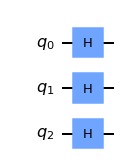

In [145]:
qc_0 = QuantumCircuit(n_qubits)
for i in range(0, n_qubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

### The Mixing Unitary

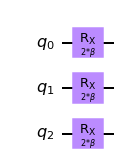

In [146]:
# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
nqubits = len(number_set)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)

for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

### The Problem Unitary

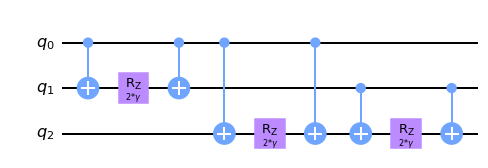

In [148]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)

for i in range(n_qubits):
    for j in range(n_qubits):
        if (i, j) in quadratic:
            qc_p.rzz(2 * gamma, i, j)
            qc_p.barrier
    
qc_p.decompose().draw('mpl')

### The QAOA circuit
So far we have seen that the preparation of a quantum state during QAOA is composed of three elements
- Preparing an initial state
- Applying the unitary $U\left(H_{P}\right)=e^{-i \gamma H_{P}}$ corresponding to the problem Hamiltonian
- Then, applying the mixing unitary $U\left(H_{B}\right)=e^{-i \beta H_{B}}$

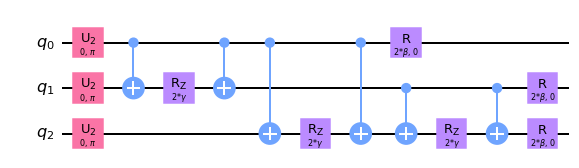

In [149]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw('mpl')

### Optimal parameters
The next step is to find the optimal parameters $\left(\boldsymbol{\beta}_{\boldsymbol{o p t}}, \boldsymbol{\gamma}_{o p t}\right)$ such that the expectation value

$$
\left\langle\psi\left(\boldsymbol{\beta}_{o p t}, \boldsymbol{\gamma}_{o p t}\right)\left|H_{P}\right| \psi\left(\boldsymbol{\beta}_{o p t}, \gamma_{o p t}\right)\right\rangle
$$

is minimized. Such an expectation can be obtained by doing measurement in the Z-basis. We use a classical optimization algorithm to find the optimal parameters. 

### Plan
1. Initialize $\boldsymbol{\beta}$ and $\boldsymbol{\gamma}$ to suitable real values.
2. Repeat until some suitable convergence criteria is met:
    1. Prepare the state $|\psi(\boldsymbol{\beta}, \boldsymbol{\gamma})\rangle$ using qaoa circuit
    2. Measure the state in standard basis
    3. Compute $\left\langle\psi(\boldsymbol{\beta}, \boldsymbol{\gamma})\left|H_{P}\right| \psi(\boldsymbol{\beta}, \boldsymbol{\gamma})\right\rangle$
    4. Find new set of parameters $\left(\boldsymbol{\beta}_{\text {new }}, \boldsymbol{\gamma}_{\text {new }}\right)$ using a classical optimization algorithm
    5. Set current parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ equal to the new parameters $\left(\boldsymbol{\beta}_{\text {new }}, \boldsymbol{\gamma}_{\text {new }}\right)$

In [133]:
def obj_f(x, QUBO):
    """        
    Returns:
        obj: float
             Objective
    """
    vector = np.unpackbits(np.array([int(x,2)], dtype=np.uint8))
    vector = np.asmatrix(vector[5:]) 
    obj = QUBO*vector.transpose()
    return np.sum(obj)

def compute_expectation(counts, QUBO):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
        
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = obj_f(bitstring, QUBO)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(theta,n):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = n
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i in range(n_qubits):
            for j in range(n_qubits):
                if (i, j) in quadratic:
                    qc.rzz(2*beta[irep], i, j)
                    qc.barrier

       
         # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2*gamma[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta,n)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        return compute_expectation(counts, QUBO)
    
    return execute_circ

In [37]:
from scipy.optimize import minimize


expectation = get_expectation(p=2)

res = minimize(expectation, [1.0, 1.0, 1.0, 1.0],  method='COBYLA')
res

     fun: -50.9169921875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48
  status: 1
 success: True
       x: array([0.45979088, 1.00366402, 1.40126267, 0.26968769])

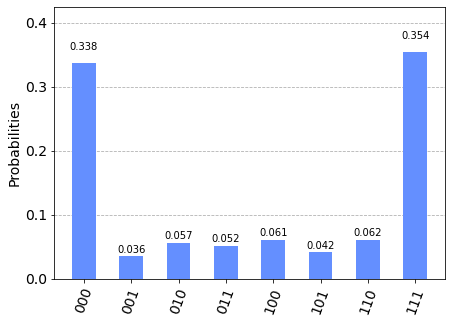

In [38]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x,n)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

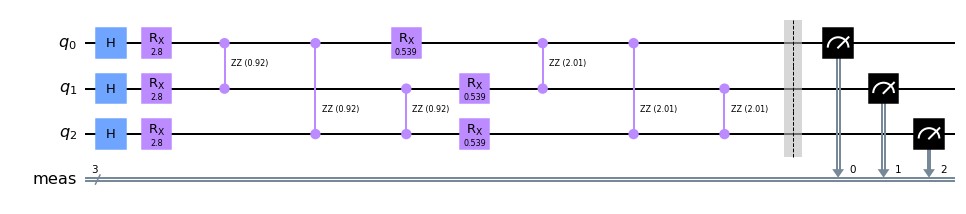

In [39]:
qc_res.draw('mpl')

In [107]:
n = len(number_set)
QUBO = fill_QUBO(number_set, S)
print(QUBO)

linear = {}
quadratic = {}
x1 = 0
while x1 < n:
    x2 = x1
    while x2 < n:
        if (x2 == x1):
            linear[(x1, x2)] = int(QUBO[x1][x2])
        else:
            quadratic[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1


[[ -57.   48.   30.]
 [   0. -112.   80.]
 [   0.    0.  -85.]]


In [108]:
quadratic

{(0, 1): 48, (0, 2): 30, (1, 2): 80}

In [109]:
def get_quadratic_problem(n_qubits, linear, quadratic):
    """
    Construct Qiskit QuadraticProgram
    """
    problem = QuadraticProgram()
    _ = [problem.binary_var("x{}".format(i)) for i in range(n_qubits)]
    problem.maximize(
        linear=linear,
        quadratic=quadratic,
    )
    return problem

In [110]:
get_quadratic_problem(n_qubits, linear, quadratic)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: - 57 x0 - 112 x1 - 85 x2 + [ 96 x0*x1 + 60 x0*x2 + 160 x1*x2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1

Binaries
 x0 x1 x2
End

In [97]:
problem = get_quadratic_problem(n_qubits, linear, quadratic)
C, offset = problem.to_ising()

In [112]:
from qiskit import BasicAer
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import QAOA

In [115]:
quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'))
qaoa_mes = QAOA(quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(problem)

C:\Users\potap\AppData\Local\Programs\Python\Python38\lib\site-packages\qiskit\aqua\algorithms\quantum_algorithm.py:46: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return aqua_globals.random


In [116]:
qaoa_result

optimal function value: 0.0
optimal value: [0. 0. 0.]
status: SUCCESS

In [98]:
from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOAAnsatz


In [99]:
p = 3
ansatz = QAOAAnsatz(C, p)

In [93]:
parameters = ansatz.parameters
ansatz = ansatz.decompose()

In [94]:
ansatz

In [95]:
counts = backend.run(ansatz, seed_simulator=10).result().get_counts()

plot_histogram(counts)

QiskitError: 'No counts for experiment "0"'

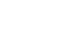

In [96]:
ansatz.draw('mpl')